## Тестовое задание: Автоматическая обрезка фигуры спортсмена в видео

#### Цель задания

Разработать Python-скрипт, который:

- Детектирует фигуру спортсмена на каждом кадре видео.

- Обрезает кадр по границам фигуры, оставляя небольшой отступ.

- Формирует выходное видео, объединяя обрезанные кадры (разного размера).

А также разработать Jupyter Notebook с анализом детекции (анализ результатов, стабильность, размеры bounding box'ов).



#### Анализ детекции:

- Отобразить боксы на кадрах.
- Построить графики изменения размера бокса от кадра к кадру.
- Рассчитать среднее и стандартное отклонение размеров bounding box'ов.
- Сделать выводы о стабильности модели.




#### Задачи

- Детектирование спортсмена на кадрах

Использовать YOLO11 для нахождения bounding box спортсмена.

- Обрезка кадра по фигуре

Для каждого кадра определить минимальный ограничивающий прямоугольник вокруг спортсмена.
Добавить небольшой отступ (margin).

- Формирование видео из обрезанных кадров

Все кадры разного размера сохранить в output/frames/.
Использовать ffmpeg или OpenCV для объединения кадров в финальное видео без искажения пропорций фигуры.

- Анализ bounding box'ов
В notebooks/analysis.ipynb выполнить:


Визуализацию bounding box'ов на кадрах.

Графики изменения площади bounding box'ов по кадрам.

Среднее и стандартное отклонение размеров боксов.

Выводы о стабильности модели.


Импортируем необходимые библиотеки.

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
import random
import matplotlib.pyplot as plt


Загрузка используемой предобученной модели YOLO11x

In [2]:
model = YOLO("yolo11x.pt")  #загрузка модели

Выведем несколько произвольных кадров с отоброжением коробок

Общее количество кадров: 201

0: 576x1024 1 person, 16224.2ms
Speed: 25.1ms preprocess, 16224.2ms inference, 14.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 15105.2ms
Speed: 34.5ms preprocess, 15105.2ms inference, 17.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 17000.3ms
Speed: 22.2ms preprocess, 17000.3ms inference, 9.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 16735.5ms
Speed: 32.7ms preprocess, 16735.5ms inference, 7.8ms postprocess per image at shape (1, 3, 576, 1024)


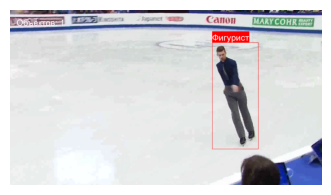

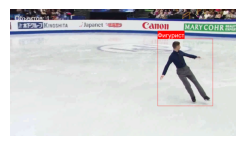

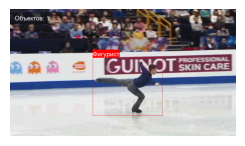

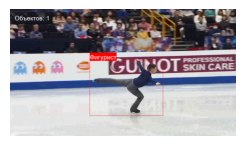

In [36]:
video_path = 'input_video.mp4' #путь к видео

cap = cv2.VideoCapture(video_path)

names = {0: "Фигурист"}
colorIndexes = {"Фигурист": (0, 0, 255)}

num_frames=4 # количество выводимых кадров

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) 
print(f"Общее количество кадров: {total_frames}")

num_frames = min(num_frames, total_frames)
random_indices = random.sample(range(total_frames), num_frames)
random_indices.sort()

margin = 20
frames = []
for index in random_indices:
    cap.set(cv2.CAP_PROP_POS_FRAMES, index)
    succes, frame = cap.read()
    if succes:
        height, width, _ = frame.shape  # Получаем размеры кадра
        results = model(frame, conf=0.2, imgsz=1024, max_det=1) # Применение модели
        clss = results[0].boxes.cls.numpy().tolist()
        boxes = results[0].boxes.xywh.numpy()
        annotator = Annotator(frame, line_width=2, example=str(names))

        for box, cls in zip(boxes, clss):
            x, y, w, h = box
            x1, y1, x2, y2 = int(x - w / 2), int(y - h / 2), int(x + w / 2), int(y + h / 2)

            # Добавление отступа
            x1 = max(0, x1 - margin)
            y1 = max(0, y1 - margin)
            x2 = min(width, x2 + margin)
            y2 = min(height, y2 + margin)

            label = int(cls)
            colorBox = colorIndexes[names[label]]
            annotator.box_label([x1, y1, x2, y2], label=names[label], color=colorBox)

        amountAllObjects = len(boxes)
        annotator.text(xy=(40, 40), text=f"Объектов: {amountAllObjects}", txt_color=(255, 255, 255))
        annotated_frame = annotator.result()  # Получение аннотированного кадра
        frames.append(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))

    else:
        print(f"Не удалось прочитать кадр {index}")

cap.release()

plt.figure(figsize=(10, 5))
for i, frame in enumerate(frames):
    plt.subplot(2, 2, i + 1)
    plt.imshow(frame)
    plt.axis('off')
    plt.show()

Расчет для построения графика изменения размера бокса от кадра к кадру.


In [32]:
cap = cv2.VideoCapture(video_path)
areas_per_frame = [] # список для суммарной площади для текущего кадра
widths = [] # список для ширины кадра
heights = [] # список для высоты кадра

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break
    

    results = model(frame, conf=0.2, imgsz=1024, max_det=1)  
    boxes = results[0].boxes.xywh.numpy()  
    frame_areas = []

    for box in boxes:
        x, y, w, h = box

        widths.append(w)
        heights.append(h)

        area = w * h #площадь
        frame_areas.append(area)

    areas_per_frame.append(sum(frame_areas)) 

cap.release()




0: 576x1024 1 person, 13831.1ms
Speed: 25.2ms preprocess, 13831.1ms inference, 7.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 12389.1ms
Speed: 25.5ms preprocess, 12389.1ms inference, 12.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 12735.7ms
Speed: 24.2ms preprocess, 12735.7ms inference, 6.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 12445.9ms
Speed: 32.3ms preprocess, 12445.9ms inference, 13.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 12281.4ms
Speed: 22.4ms preprocess, 12281.4ms inference, 12.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 12578.4ms
Speed: 31.7ms preprocess, 12578.4ms inference, 8.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 12404.4ms
Speed: 35.3ms preprocess, 12404.4ms inference, 8.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 12556.1ms
Speed: 36.0ms prepr

Построение графика изменение площади bounding box

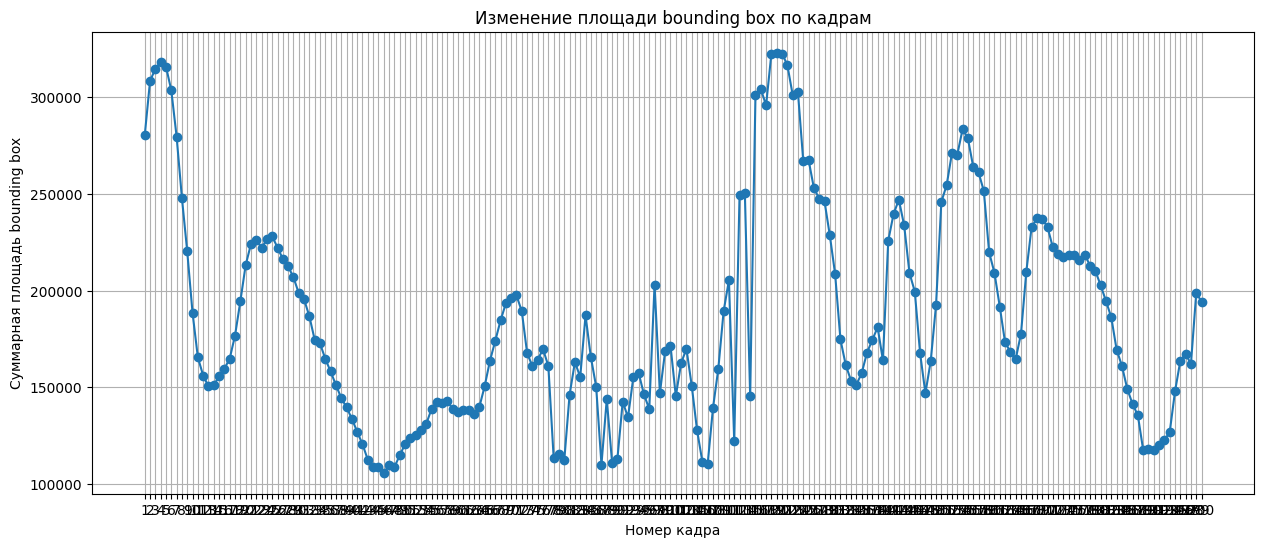

In [33]:
plt.figure(figsize=(15, 6))
plt.plot(range(1, len(areas_per_frame) + 1), areas_per_frame, marker='o')
plt.title('Изменение площади bounding box по кадрам')
plt.xlabel('Номер кадра')
plt.ylabel('Суммарная площадь bounding box')
plt.grid()
plt.xticks(range(1, len(areas_per_frame) + 1))
plt.show()

По графику можем увидеть плавное начало и завершение видео, модель отрабатывает стабильно. Но в середине есть несколько резких скачков. В один момент теряет объект. Вероятно при резком движении, изменении положения объекта.



Расчет среднего значения и стандартного отклонения высоты и ширины полученных кадров

In [35]:
mean_width = np.mean(widths)
mean_height = np.mean(heights)
std_width = np.std(widths)
std_height = np.std(heights)

# Вывод результатов
print(f'Средняя ширина: {mean_width:.2f}')
print(f'Средняя высота: {mean_height:.2f}')
print(f'Стандартное отклонение ширины: {std_width:.2f}')
print(f'Стандартное отклонение высоты: {std_height:.2f}')

Средняя ширина: 345.33
Средняя высота: 543.53
Стандартное отклонение ширины: 100.30
Стандартное отклонение высоты: 72.11


Средняя ширина бокса составляет 345.33 пикселя, а средняя высота — 543.53 пикселя. Эти значения указывают на то, что модель в среднем определяет размеры объекта (фигуриста) достаточно стабильно и близко к ожидаемым размерам.

Ширина: стандартное отклонение ширины 100.30 относительно велико по сравнению со средней шириной 345.33. Это может указывать на некоторую нестабильность в определении ширины бокса, возможно, из-за изменений положения фигуриста в кадре.

Высота: стандартное отклонение высоты 72.11 меньше по сравнению со средней высотой 543.53, что свидетельствует о более стабильной работе модели в определении высоты бокса.

Вывод

Модель в целом показывает приемлемую стабильность в определении размеров объекта, особенно по высоте. Однако есть некоторые колебания в определении ширины, что может потребовать дополнительного анализа и возможной корректировки модели для улучшения точности обнаружения.